In [1]:
import numpy as np
import matplotlib.pyplot as plt
from load_gestures import load_gestures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### Cargamos los gestos mediante la función `load_gestures()` escrita por nosotros

In [2]:
df = load_gestures("files/")

In [3]:
df.shape

(20628, 9)

### Checamos duplicados, omitimos el temporal_point igual a cero ya que hay muchos con valores iguales. Queremos solamente gestos completos

In [4]:
duplicates = df[df["temporal_point"] != 0]

duplicates = duplicates[duplicates.duplicated(
    subset=["temporal_point", "x", "y", "height", "width", "finger_pressure"])]

unique_gestures = duplicates.groupby(["user", "gesture"])["sample"].nunique()

print(f"Columnas duplicadas: {len(duplicates)}")
print(f"Gestos duplicados: {len(unique_gestures)}")

Columnas duplicadas: 14
Gestos duplicados: 1


In [5]:
duplicates_to_drop = duplicates[["user", "gesture", "sample"]].drop_duplicates()

In [6]:
df = df.merge(duplicates_to_drop, on=["user", "gesture", "sample"], how="left", indicator=True)

df = df[df["_merge"] == "left_only"].drop(columns="_merge")

In [7]:
df.shape

(20613, 9)

In [ ]:
max_rows = max(len(sample_df) for _, sample_df in df.groupby(["user","gesture","sample"]))

X = []
y = []

# Agrupar por muestra
for (_, gesture, _), sample_df in df.groupby(["user","gesture","sample"]):
    feature_vector = sample_df[["x", "y", "height", "width", "finger_pressure"]].values.flatten()
    pad_length = max_rows*5 - len(feature_vector)  # 5 columns per row
    if pad_length > 0:
        feature_vector = np.pad(feature_vector, (0, pad_length), 'constant')
    X.append(feature_vector)
    y.append(gesture)

X = np.array(X)
y = np.array(y)

In [9]:
users = np.array([user for (user, _, _) in df.groupby(["user","gesture","sample"]).groups.keys()])
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=users))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

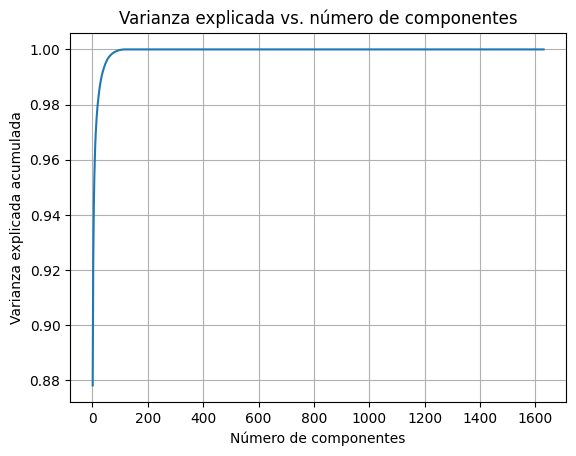

In [11]:
pca = PCA()
pca.fit(X_train_scaled)

explained_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada vs. número de componentes")
plt.grid(True)
plt.show()

In [12]:
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Número de componentes para una varianza de 95%: {n_components_95}")

Número de componentes para una varianza de 95%: 7


In [13]:
pca = PCA(n_components=n_components_95)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [14]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_reduced, y_train)

,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [15]:
y_pred = knn.predict(X_test_reduced)
print("Precisión:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Precisión: 0.9369158878504673
              precision    recall  f1-score   support

  gesture_01       1.00      0.96      0.98        57
  gesture_02       0.95      0.96      0.95        54
  gesture_03       0.93      0.93      0.93        54
  gesture_04       0.95      0.90      0.92        60
  gesture_05       0.95      0.95      0.95        56
  gesture_06       0.97      0.84      0.90        38
  gesture_07       0.94      0.94      0.94        54
  gesture_08       0.84      0.98      0.91        55

    accuracy                           0.94       428
   macro avg       0.94      0.93      0.94       428
weighted avg       0.94      0.94      0.94       428



In [16]:
groups = users

In [17]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components_95)),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

In [18]:
gkf = GroupKFold(n_splits=5)
scores = cross_val_score(pipeline, X, y, cv=gkf, groups=groups)

In [19]:
print("Cross-validated accuracies:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracies: [0.92051282 0.98117647 0.62098501 0.8358209  0.945     ]
Mean accuracy: 0.8606990394660163
